In [10]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from SimPEG.EM.Static import Utils as StaticUtils
from pymatsolver import MumpsSolver
import timeit
import itertools
sys.path.append("../notebooks/utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# xc = 300+5.57e5
# yc = 600+7.133e6
# zc = 425.
# mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]
sigma = mesh.readModelUBC("../notebooks/DC/VTKout_DC.dat")
airind = sigma == 1e-8

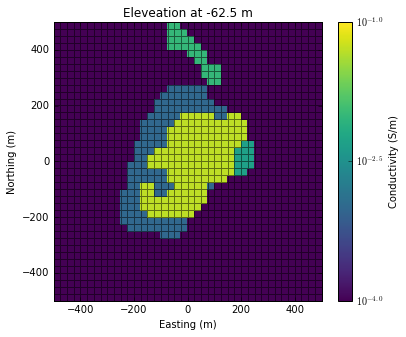

In [38]:
viz(mesh, sigma, 28, airind)

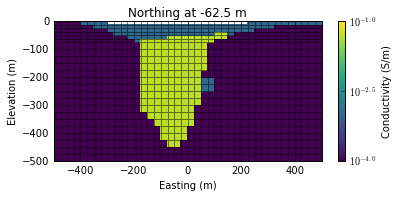

In [39]:
viz(mesh, sigma, 28, airind, normal="Y")

(<matplotlib.collections.QuadMesh at 0x116abd490>,
 <matplotlib.lines.Line2D at 0x116abda10>)

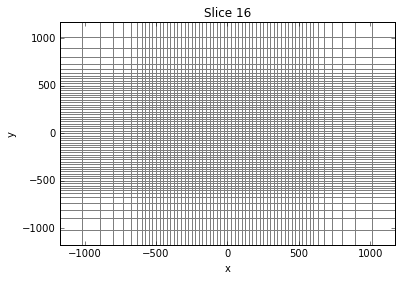

In [43]:
mesh.plotSlice(sigma*np.nan, grid=True)

In [57]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -1171.44
   y0: -1171.44
   z0: -1146.44
  nCx: 62
  nCy: 62
  nCz: 33
   hx: 156.87, 120.67, 92.82, 71.40, 54.93, 42.25, 32.50, 48*25.00, 32.50, 42.25, 54.93, 71.40, 92.82, 120.67, 156.87
   hy: 156.87, 120.67, 92.82, 71.40, 54.93, 42.25, 32.50, 48*25.00, 32.50, 42.25, 54.93, 71.40, 92.82, 120.67, 156.87
   hz: 156.87, 120.67, 92.82, 71.40, 54.93, 42.25, 32.50, 20*25.00, 6*12.50


In [56]:
print  mesh.vectorCCz

[-1068.00662125  -929.2358625   -822.489125    -740.37625     -677.2125
  -628.625       -591.25        -562.5         -537.5         -512.5
  -487.5         -462.5         -437.5         -412.5         -387.5
  -362.5         -337.5         -312.5         -287.5         -262.5
  -237.5         -212.5         -187.5         -162.5         -137.5
  -112.5          -87.5          -68.75         -56.25         -43.75
   -31.25         -18.75          -6.25      ]


In [40]:
# Identify air cells
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [58]:
dx = 25.
x0_core, y0_core, z0_core = -600, -600, -500. 

In [84]:
np.arange(7)*100 + -312.5

array([-312.5, -212.5, -112.5,  -12.5,   87.5,  187.5,  287.5])

In [73]:
mesh.vectorCCx

array([-1093.00662125,  -954.2358625 ,  -847.489125  ,  -765.37625   ,
        -702.2125    ,  -653.625     ,  -616.25      ,  -587.5       ,
        -562.5       ,  -537.5       ,  -512.5       ,  -487.5       ,
        -462.5       ,  -437.5       ,  -412.5       ,  -387.5       ,
        -362.5       ,  -337.5       ,  -312.5       ,  -287.5       ,
        -262.5       ,  -237.5       ,  -212.5       ,  -187.5       ,
        -162.5       ,  -137.5       ,  -112.5       ,   -87.5       ,
         -62.5       ,   -37.5       ,   -12.5       ,    12.5       ,
          37.5       ,    62.5       ,    87.5       ,   112.5       ,
         137.5       ,   162.5       ,   187.5       ,   212.5       ,
         237.5       ,   262.5       ,   287.5       ,   312.5       ,
         337.5       ,   362.5       ,   387.5       ,   412.5       ,
         437.5       ,   462.5       ,   487.5       ,   512.5       ,
         537.5       ,   562.5       ,   587.5       ,   616.25      ,
      

In [131]:
# Define electrode locations

elecSpace = 100.
coreOffset = 100 + dx/2.

# x locations
# elecX = np.linspace(x0_core + coreOffset , np.abs(x0_core) - coreOffset, num=((2*(np.abs(x0_core)-coreOffset))/elecSpace) + 1)
# nElecX = elecX.size
# y locations
# elecY = np.linspace(y0_core + coreOffset , np.abs(y0_core) - coreOffset, num=((2*(np.abs(y0_core)-coreOffset))/elecSpace) + 1)
# nElecY = elecY.size

# Insure that electrode x and y locations fall at cell centres
nskip = 4
elecX = mesh.vectorCCx[np.logical_and(mesh.vectorCCx > -300, mesh.vectorCCx < 320)][::nskip]
elecY = mesh.vectorCCy[np.logical_and(mesh.vectorCCy > -300, mesh.vectorCCy < 320)][::nskip]
nElecX = elecX.size
nElecY = elecY.size

elecX_grid,elecY_grid = np.meshgrid(elecX,elecY)

EW_Lines_Locs = []
EW_Lines_Id =[]
for ii in range(0, nElecY): 
    EW_Lines_Locs.append(np.vstack([elecX_grid[ii,:], elecY_grid[ii,:]]).T)
    EW_Lines_Id.append(np.arange(nElecX*ii,nElecX*ii + nElecX,1))
    
# Create full electrode key which maps electrode Ids and locations
elecLoc = np.vstack(EW_Lines_Locs)

# Drape to topography to get z-value
elecCC_Inds = Utils.closestPoints(mesh2D, elecLoc)
elecLoc_topo = np.c_[elecLoc[:,0], elecLoc[:,1], topoCC[elecCC_Inds]]

nElec = elecLoc_topo.shape[0]
elecId = np.arange(0,nElec,1)
elecLocKey = np.hstack([Utils.mkvc(elecId,2),elecLoc_topo])    

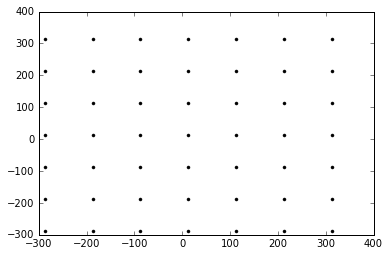

In [132]:
plt.plot(elecX_grid, elecY_grid, 'k.')

In [133]:
# Create dipole-dipole sequence for each EW line

# Identify Tx dipoles on each line
EW_Line_TxElecInd = []
EW_LineId = []
EW_nLines = nElecY
for nr, Line_ElecIds in enumerate(EW_Lines_Id):
    Line_nElec = Line_ElecIds.shape[0]
    for ii in Line_ElecIds[0:-1]:
        for jj in np.arange(ii+1,np.max(Line_ElecIds)+1,1):
            EW_Line_TxElecInd.append([ii , jj])
            EW_LineId.append([nr])

EW_Line_TxElecInd = np.array(EW_Line_TxElecInd)
EW_LineId = np.array(EW_LineId)
nTx = np.array(EW_Line_TxElecInd).shape[0]  
nTx_Line = nTx/EW_nLines

# print nTx
# print nTx_Line
# print EW_Line_TxElecInd[0:nTx_Line,:]
    

In [123]:
# len(EW_Line_TxElecInd) / 7

21

In [124]:
# print EW_Line_TxElecInd.shape

(147, 2)


In [137]:
EW_Line_TxElecInd

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 4,  5],
       [ 4,  6],
       [ 5,  6],
       [ 7,  8],
       [ 7,  9],
       [ 7, 10],
       [ 7, 11],
       [ 7, 12],
       [ 7, 13],
       [ 8,  9],
       [ 8, 10],
       [ 8, 11],
       [ 8, 12],
       [ 8, 13],
       [ 9, 10],
       [ 9, 11],
       [ 9, 12],
       [ 9, 13],
       [10, 11],
       [10, 12],
       [10, 13],
       [11, 12],
       [11, 13],
       [12, 13],
       [14, 15],
       [14, 16],
       [14, 17],
       [14, 18],
       [14, 19],
       [14, 20],
       [15, 16],
       [15, 17],
       [15, 18],
       [15, 19],
       [15, 20],
       [16, 17],
       [16, 18],
       [16, 19],
       [16, 20],
       [17, 18],
       [17, 19

In [157]:
dataDict = {}
# nRxList = []
# Iterate over Tx and select possible Rx for each
# nTx = 7 # just for testing
for nr, Tx in enumerate(EW_Line_TxElecInd):
    LineId = EW_LineId[nr]
    useableRxElecs = np.setdiff1d(EW_Lines_Id[LineId[0]],Tx)
    RxPairs = itertools.combinations(useableRxElecs,2) # n choose k combinations
    
    # Extract data from combinations object
    RxPairList = []
    for ii in RxPairs:
        RxPairList.append(tuple(ii))

    RxPairArray = np.array(RxPairList, dtype=int)
    nRx = RxPairArray.shape[0]
#     nRxList.append([nRx])
    
    A = Tx[0]*np.ones((nRx,1), dtype=int)
    B = Tx[1]*np.ones((nRx,1), dtype=int)
    LineIdVec = LineId*np.ones((nRx,1), dtype=int)
    dataArray = np.hstack([LineIdVec,A,B,RxPairArray])
    dataDict[nr] = dataArray

In [158]:
dataDict[0]

array([[0, 0, 1, 2, 3],
       [0, 0, 1, 2, 4],
       [0, 0, 1, 2, 5],
       [0, 0, 1, 2, 6],
       [0, 0, 1, 3, 4],
       [0, 0, 1, 3, 5],
       [0, 0, 1, 3, 6],
       [0, 0, 1, 4, 5],
       [0, 0, 1, 4, 6],
       [0, 0, 1, 5, 6]])

In [153]:
dataDict[0][2, :]

array([ 0.,  0.,  1.,  2.,  5.])

In [154]:
dataDict[0][3, :]

array([ 0.,  0.,  1.,  2.,  6.])

In [164]:
dataDict[0][:,3]

array([2, 2, 2, 2, 3, 3, 3, 4, 4, 5])

In [183]:
# ALoc, BLoc

In [182]:
# plt.plot(ALoc[0], ALoc[1], 'b.')
# plt.plot(BLoc[0], BLoc[1], 'r.')
# plt.plot(MLoc[:,0], MLoc[:,1], 'ko')
# plt.plot(NLoc[:,0], NLoc[:,1], 'go')

In [172]:
MLoc

array([[ -87.5 , -287.5 ,  -18.75],
       [ -87.5 , -287.5 ,  -18.75],
       [ -87.5 , -287.5 ,  -18.75],
       [ -87.5 , -287.5 ,  -18.75],
       [  12.5 , -287.5 ,  -18.75],
       [  12.5 , -287.5 ,  -18.75],
       [  12.5 , -287.5 ,  -18.75],
       [ 112.5 , -287.5 ,  -18.75],
       [ 112.5 , -287.5 ,  -18.75],
       [ 212.5 , -287.5 ,  -18.75]])

In [186]:
srcLists = []
for itx in range (nTx):   
    ALoc = elecLocKey[:,1:][dataDict[itx][0,1],:]
    BLoc = elecLocKey[:,1:][dataDict[itx][0,2],:]
    MLoc = elecLocKey[:,1:][dataDict[itx][:,3],:]
    NLoc = elecLocKey[:,1:][dataDict[itx][:,4],:]    
    rx = DC.Rx.Dipole(MLoc, NLoc)
    src = DC.Src.Dipole([rx], np.array(ALoc),np.array(BLoc))
    srcLists.append(src)

In [187]:
# Model mappings 
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

In [188]:
# reference model
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [21]:
# Setup forward modelling
survey = DC.Survey([TxData])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
startTime = timeit.timeit()
f = problem.fields(mtrue)
endTime = timeit.timeit()
print endTime - startTime
dobs = survey.dpred(mtrue, f=f)
survey.dobs = dobs

TypeError: not all arguments converted during string formatting

In [ ]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=5)
# ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=5)
# ax.plot(Aloc2_x[0], Aloc2_x[1], 'ro', ms=5)
# ax.plot(Bloc2_x[0], Bloc2_x[1], 'bo', ms=5)
# ax.plot(Aloc1_y[0], Aloc1_y[1], 'ro', ms=5)
# ax.plot(Bloc1_y[0], Bloc1_y[1], 'bo', ms=5)
# ax.plot(Aloc2_y[0], Aloc2_y[1], 'ro', ms=5)
# ax.plot(Bloc2_y[0], Bloc2_y[1], 'bo', ms=5)

# ax.plot(Mx[:,0], Mx[:,1], 'k.', ms=2)
# ax.plot(Nx[:,0], Nx[:,1], 'g.', ms=2)

# # ax.plot(My[:,0], My[:,1], 'k.', ms=2)
# # ax.plot(Ny[:,0], Ny[:,1], 'g.', ms=2)
# # dat = mesh2D.plotImage(topoCC, ax=ax, pcolorOpts={'alpha':0.2})
# # plt.colorbar(dat[0])
# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 800)
# ax.set_xlabel("Easting (m)")
# ax.set_ylabel("Northing (m)") 

In [ ]:
from ipywidgets import interact, IntSlider
def viz(sigma, ind, normal="Z"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan
    dat = mesh.plotSlice(np.log10(sigma), ind=ind, clim=(-4, -1), normal=normal, grid=True)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-600, 0.)     
    cb = plt.colorbar(dat[0], format="$10^{%1.1f}$")        
    cb.set_label("Conductivity (S/m)")
    plt.title(" ")

In [ ]:
from ipywidgets import interact, IntSlider
def vizEJ(sigma, ind, normal="Z", ftype="E"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan

    if ftype == "E":
#         vmin, vmax = abs(f[src1,'e']).min(), abs(f[src1,'e']).max()*0.5   
        dat=mesh.plotSlice(f[src1,'e'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric fields (V/m)")
    elif ftype == "charg":
        dat=mesh.plotSlice(f[src1,'charge'], ind=ind, normal=normal)
        plt.title("Electric charges (C)")        
    elif ftype == "J":
        dat=mesh.plotSlice(f[src1,'j'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric currents (V/m)")
    plt.xlabel("Easting (m)")
    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
        plt.ylabel("Northing (m)")        
    else:
        xlim(-600, 600)
        ylim(-600, 0.)  
        plt.ylabel("Depth (m)")
    plt.colorbar(dat[0], format="%1.1e")

In [ ]:
def vizdata(data, src, rx, rxcomponent="X", clim=None):
    figsize(5,5)
    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()        
    else:
        X = Xy.copy()
        Y = Yy.copy()      
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = plt.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax)
    else:
        dat = plt.contourf(X, Y, temp, 20)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")            
    plt.colorbar(dat)

<function __main__.<lambda>>

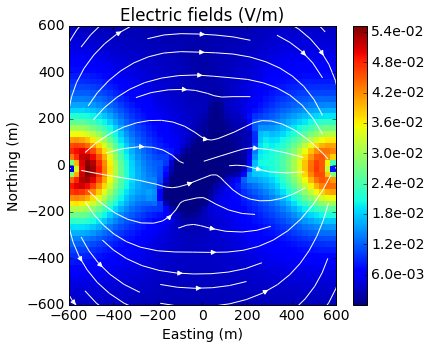

In [19]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="E"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

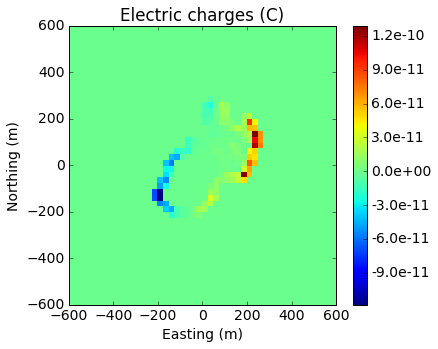

In [20]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

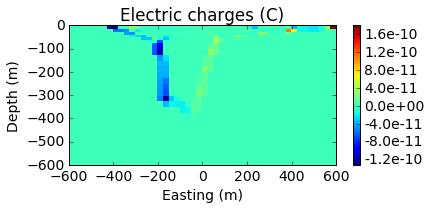

In [21]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

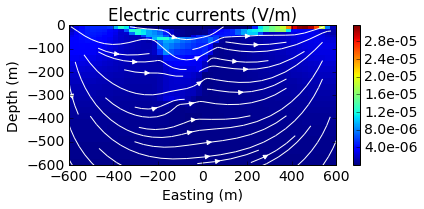

In [22]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="J"), ind=IntSlider(min=0, max=32,step=1, value=25))

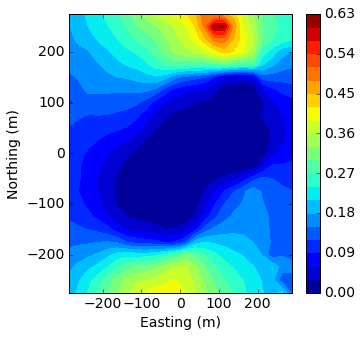

In [23]:
vizdata(dcdata, src3, rx_y, rxcomponent="Y")

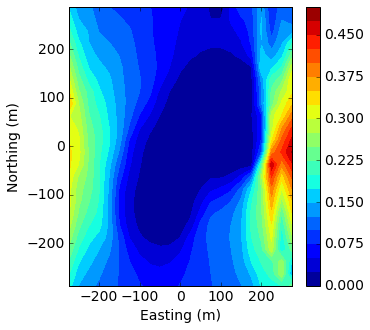

In [24]:
vizdata(dcdata, src1, rx_x, rxcomponent="X")

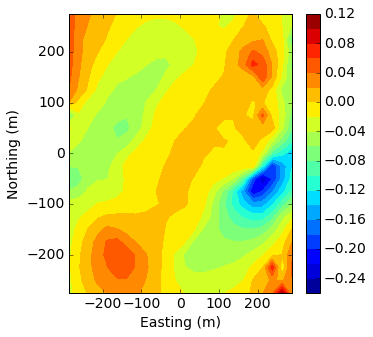

In [25]:
vizdata(dcdata, src1, rx_y, rxcomponent="Y")

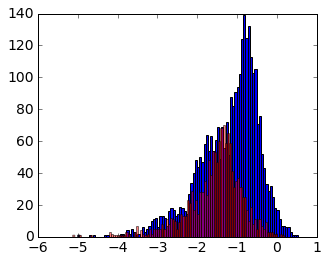

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [27]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

(-600, 0.0)

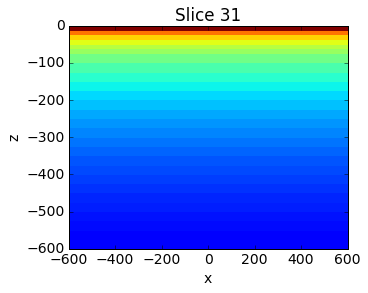

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 0.)    

In [29]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# mopt = inv.run(m0)
# sigopt = mapping*mopt
# np.save("sigest", sigopt)

In [30]:
sigopt = np.load("sigest.npy")
# sigopt = mapping*mopt

In [31]:
from SimPEG import Survey
# datapred = invProb.dpred
# obsdata = Survey.Data(survey, v=dobs)
# preddata = Survey.Data(survey, v=datapred)

In [32]:
# figsize(8,3)
# plt.plot(obsdata[src1, rx_y])
# plt.plot(preddata[src1, rx_y], '.')

<function __main__.<lambda>>

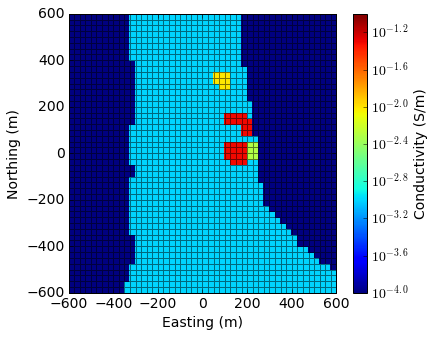

In [33]:
interact(lambda ind: viz(sigma, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

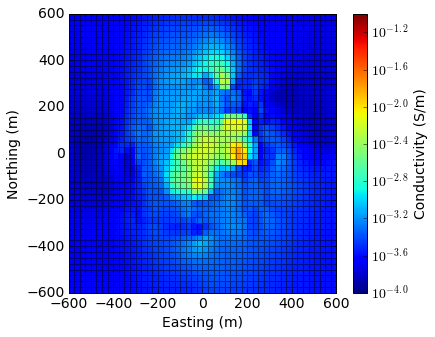

In [34]:
interact(lambda ind: viz(sigopt, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

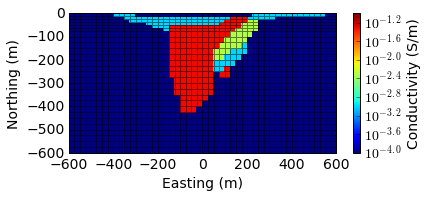

In [35]:
interact(lambda ind: viz(sigma, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

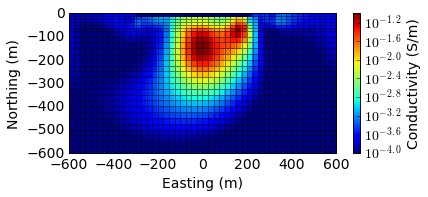

In [36]:
interact(lambda ind: viz(sigopt, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [37]:
import pickle
Results = {"mesh":mesh, "model_true":sigma, "model_pred":sigopt, "Obs":dobs}
outputs = open("DCresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()